<b>Latent Semantic Analysis</b>

Latent semantic analysis is used in the analysis of different words which have the same meaning. LSA assumes that words that are close in meaning will occur in similar pieces of text.<br>
<b>A good definition</b> ->https://en.wikipedia.org/wiki/Latent_semantic_analysis.<br> Its basically used to analyse patterns which exist between terms and concepts in a text. 

<b>Diagram:<br>As depicted in the below diagram, if 2 words have the same meaning, searching for docs containing the 1st word would also return the results pertaining to the 2nd word(since they'd belong to the same concept.)</b>
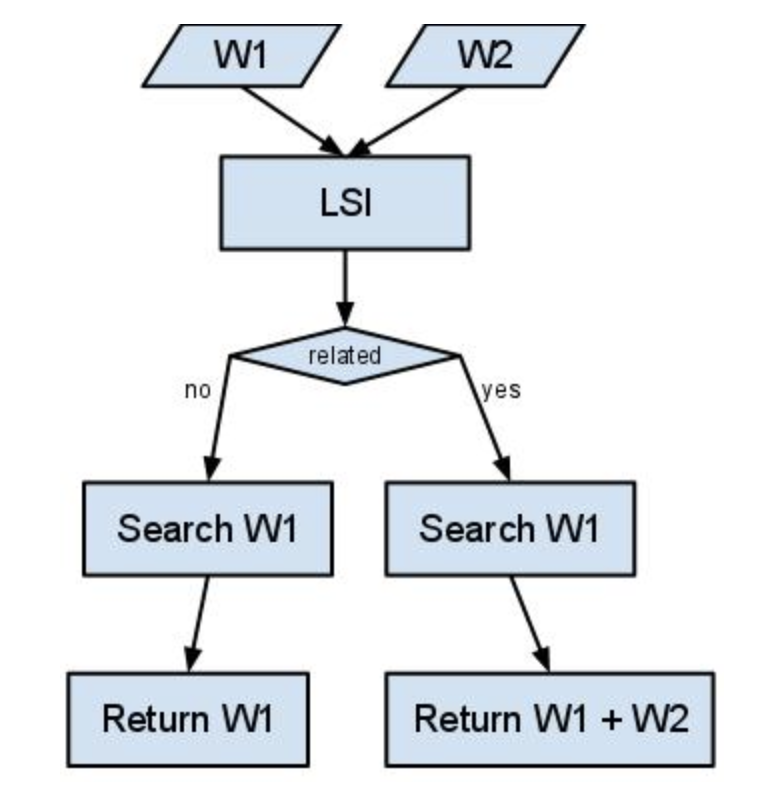


<b>Steps for LSA:</b>
1. For each document, calculate the document-term matrix. This gives the counts of each term occuring in a particular document.<br>
<br>

2. Perform SVD to reduce the features. This step will take care of grouping words with similar meanings together, in order to get less but better new features.(More explaination of SVD will come below)<br>
<br>

3. Now, run the appropriate classifier on this new dataset to obtain accuracy scores.<br>

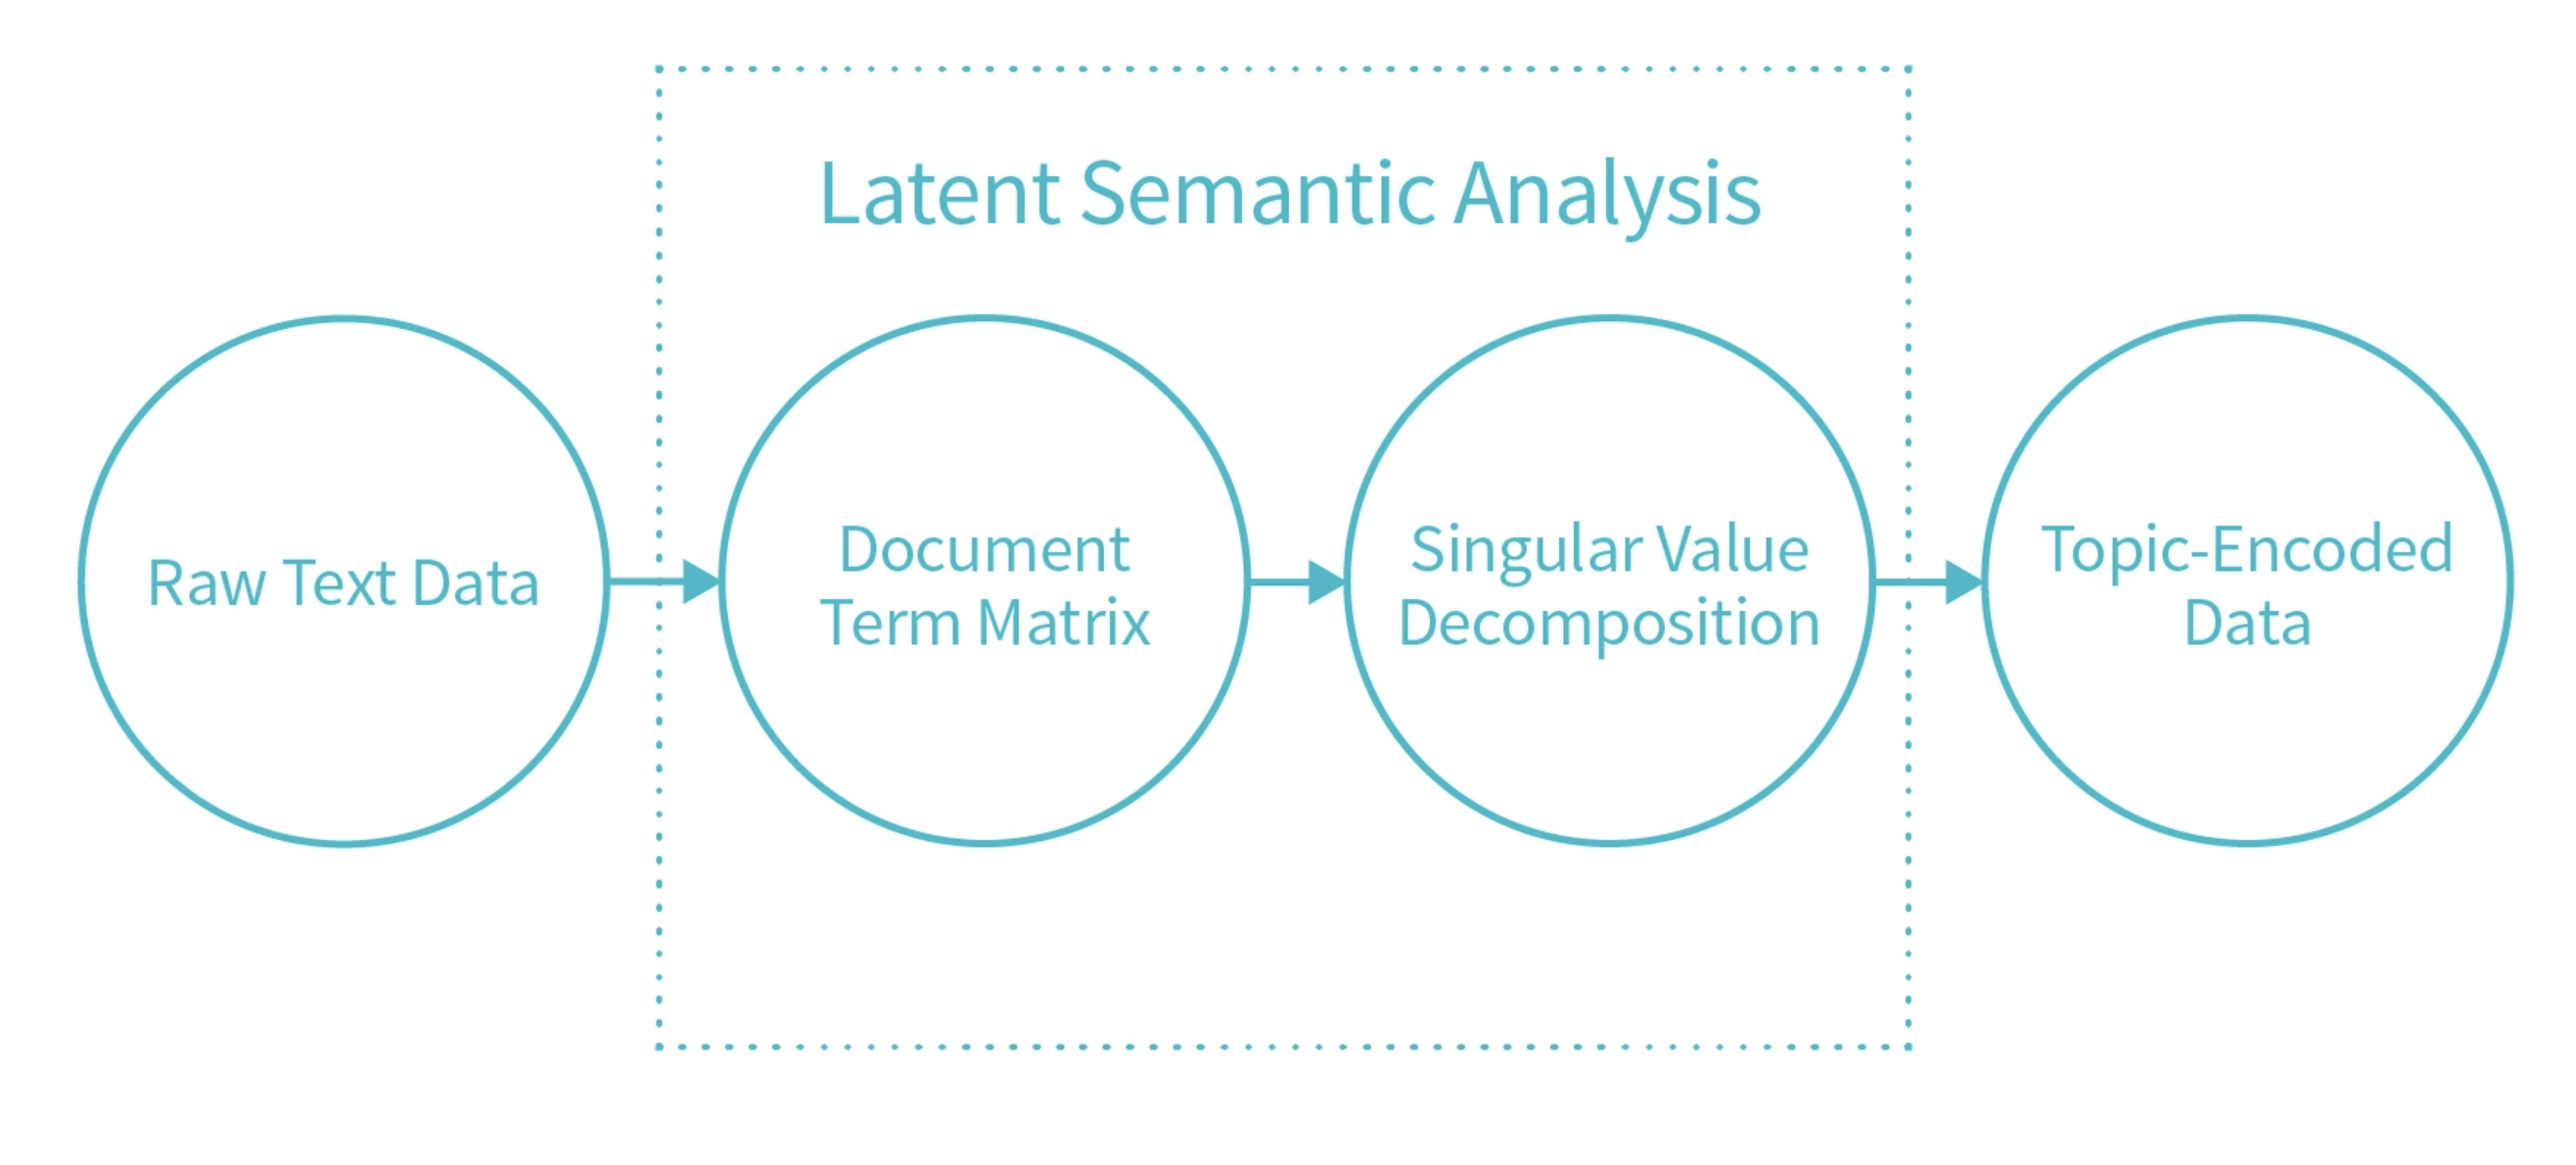


In [9]:
import pickle
import time
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

The data set used is "Amazon food-review" dataset from kaggle.(https://www.kaggle.com/snap/amazon-fine-food-reviews).
This contains User reviews for different products(indexed by ProductId), and a score given by them. Our algorithm in LSA would assume that people who have given higher ratings would use similar words in their reviews and same for the people who have given bad reviews. 
As an example, although the high rated reviews may contain words like  "good", "fair", "nice",etc. svd would group them fewer features instead(say maybe 1 for all the 3 words). And based on the count of these words, the ML algorithm can find relations between term counts and score.

In [53]:
df = pd.read_csv('./amazon-fine-food-reviews/Reviews.csv')
# print(df.shape)
df = df.head(40000)
print(df.head())
# df.columns

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

Just need the text for semantic analysis, thus taking 'Text' column only.

In [54]:
df['ProductId'].head()
X_orig = df[['HelpfulnessNumerator',
       'HelpfulnessDenominator']]
X = df[['HelpfulnessNumerator',
       'HelpfulnessDenominator','Text']]
X

,HelpfulnessNumerator,HelpfulnessDenominator,Text
0,1,1,I have bought several of the Vitality canned d...
1,0,0,Product arrived labeled as Jumbo Salted Peanut...
2,1,1,This is a confection that has been around a fe...
3,3,3,If you are looking for the secret ingredient i...
4,0,0,Great taffy at a great price. There was a wid...
...,...,...,...
39995,4,4,"I've tried a wide variety of popcorns, and gen..."
39996,3,3,"I am unable to buy ""hulless"" popcorn in my are..."
39997,2,2,"Even ""no hull"" popcorn has hulls. It has to s..."
39998,2,2,"When I bought this popcorn, it was because Ama..."


Using binary classification

In [55]:
Y = df['Score']
Y = Y.replace([0, 1, 2], 0)
Y = Y.replace([3, 4, 5], 1)
Y

0        1
1        0
2        1
3        0
4        1
        ..
39995    1
39996    1
39997    1
39998    1
39999    1
Name: Score, Length: 40000, dtype: int64

In [39]:
X['Text'].tolist()

['I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.',
 'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".',
 'This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis\' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.',
 'If you are looking f

<b>Here, we train our model without using LSA, using just the 'Helpfulness Numerator' and 'Helpfulness Denominator' features.</b>

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(X_orig, Y, test_size=0.33, random_state=42)
classifier = KNeighborsClassifier(n_neighbors=10)
classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)
print("Accuracy Score without applying Latent Semantic Analysis =", accuracy_score(Y_pred,Y_test))

Accuracy Score without applying Latent Semantic Analysis = 0.8459090909090909


<b>TfidfVectorizer is used to find the document-term matrix. For us, its the term tf-idf scores for each of the documents.</b>

In [56]:
tf_idf = TfidfVectorizer( max_features=30000)
X = tf_idf.fit_transform(X['Text'])

In [57]:
print(type(X))
X.shape

<class 'scipy.sparse.csr.csr_matrix'>


(40000, 30000)

<b>SVD used for dimensionality reduction to just 100 features.</b><br>

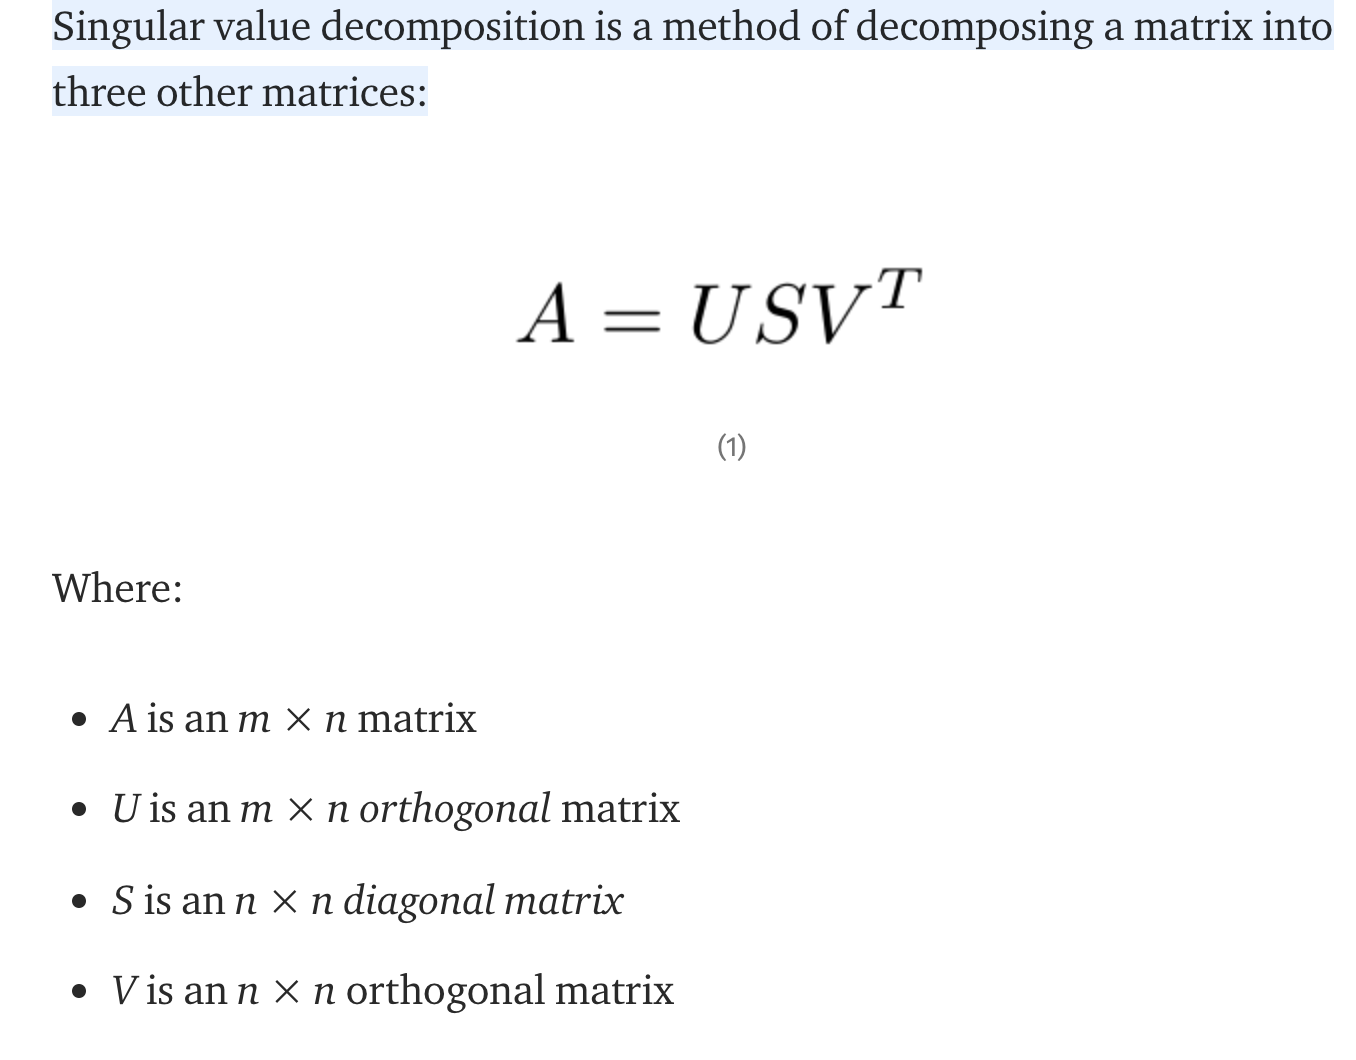
SVD is used to find the concepts in the given text. Its done by firstly dividing the matrix(which is the tf-idf scores for each term) into 3 matrices U, S and V, where S is the concept matrix indicating the strength of the concepts. For eg: in our case words like 'good', 'excellent', 'marvelous' can belong to a 'GOOD' concept, 'okayish', 'fair', 'so so' can belong to a 'MODERATE' concept and eords like 'yuck', 'eww', ''awful' can belong to a 'BAD' concept.
Here S is the matrix indicating document's score for each of the concepts and V indicates the scores after grouping the terms/words into concepts.

In [58]:
svd = TruncatedSVD(100)
lsa = make_pipeline(svd, Normalizer(copy=False))

X = lsa.fit_transform(X)
X

array([[ 0.49311167,  0.05245672, -0.12855634, ..., -0.0564977 ,
        -0.03922818, -0.05930918],
       [ 0.41736239, -0.01017568, -0.01440996, ...,  0.10218163,
        -0.01868469,  0.07117392],
       [ 0.68057316, -0.12096208, -0.10383734, ..., -0.00335867,
         0.00988636,  0.01363772],
       ...,
       [ 0.33000079, -0.04236944, -0.04256529, ..., -0.01298593,
        -0.04815155, -0.01690121],
       [ 0.45155515, -0.15568613, -0.0953441 , ..., -0.00611307,
        -0.00842489,  0.09051739],
       [ 0.58185777, -0.01325128,  0.18429151, ..., -0.01665059,
         0.03132853,  0.01891322]])

Above indicates the doc-concept scores after retrieving concepts from SVD algorithm
<br>
<b>Taken 67% of data fo training and 33% for testing</b>

In [59]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

Using K-NN classifier for training data

In [60]:
classifier = KNeighborsClassifier(n_neighbors=10)
classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)
print("Accuracy Score after applying Latent Semantic Analysis=", accuracy_score(Y_pred,Y_test))

Accuracy Score after applying Latent Semantic Analysis= 0.8571212121212122


<b>Results Comparison:</b>

Without using LSA on the Text we had corresponding to the Amazon food reviews, we achieved an accuracy of <b>84.59%</b> whereas after using LSA we increases the accuracy score to <b>85.71%</b>

<b>References:</b><br>
1) Latent Semantic Analysis (LSA) for Text Classification Tutorial - https://mccormickml.com/2016/03/25/lsa-for-text-classification-tutorial/

2) An introduction to Latent Semantic Analysis - https://pdfs.semanticscholar.org/23bc/fedcbcdc0789e64995222827ee8fdf9aba3a.pdf

3) Latent Semantic Analysis in Python - http://blog.josephwilk.net/projects/latent-semantic-analysis-in-python.html
    
    